In [47]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import sys
import time
import random
import tensorflow as tf
from tensorflow import keras
import h5py

os.environ["TF_CPP_MIN_LOG_LEVEL"] = "0"
#tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
"""
config = tf.compat.v1.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.6  # 程序最多只能占用指定gpu50%的显存
config.gpu_options.allow_growth = True      #程序按需申请内存
sess = tf.compat.v1.Session(config = config)
"""

'\nconfig = tf.compat.v1.ConfigProto()\nconfig.gpu_options.per_process_gpu_memory_fraction = 0.6  # 程序最多只能占用指定gpu50%的显存\nconfig.gpu_options.allow_growth = True      #程序按需申请内存\nsess = tf.compat.v1.Session(config = config)\n'

1. loads data
2. preprocesses data -> dataset
3. tools
    1. generates position embedding
    2. create mask. (a. padding, b. decoder)
    3. scaled_dot_product_attention
4. builds model
    1. MultiheadAttention
    2. EncoderLayer
    3. DecoderLayer
    4. EncoderModel
    5. DecoderModel
    6. Transformer
5. optimizer & loss
6. train step -> train
7. Evaluate and Visualize


# Build model

### Calc Attention

In [8]:
def scaled_dot_product_attention(q, k, v, mask):
    """
    Args:
    - q: shape == (..., seq_len_q, depth)
    - k: shape == (..., seq_len_k, depth)
    - v: shape == (..., seq_len_v, depth_v)
    - seq_len_k == seq_len_v
    - mask: shape == (..., seq_len_q, seq_len_k)
    Returns:
    - output: weighted sum
    - attention_weights: weights of attention
    """
    
    # matmul_qk.shape: (..., seq_len_q, seq_len_k)
    matmul_qk = tf.matmul(q, k, transpose_b = True)
    
    dk = tf.cast(tf.shape(k)[-1], tf.float32)
    scaled_attention_logits = matmul_qk / tf.math.sqrt(dk)
    
    if mask is not None:
        # 使得在softmax后值趋近于0
        """在mask里，应该被忽略的我们会设成1，应该被保留的会设成0，而如果mask相应位置上为1，
        那么我们就给对应的logits 加上一个超级小的负数， -1000000000， 这样，对应的logits也就变成了一个超级小的数。
        然后在计算softmax的时候，一个超级小的数的指数会无限接近与0。也就是它对应的attention的权重就是0了。"""
        scaled_attention_logits += (mask * -1e9)
    
    # attention_weights.shape: (..., seq_len_q, seq_len_k)
    attention_weights = tf.nn.softmax(
        scaled_attention_logits, axis = -1)
    
    # output.shape: (..., seq_len_q, depth_v)
    output = tf.matmul(attention_weights, v)
    
    return output, attention_weights


In [4]:
def print_scaled_dot_product_attention(q, k, v):
    temp_out, temp_att = scaled_dot_product_attention(q, k, v, None)
    print("Attention weights are:")
    print(temp_att)
    print("Output is:")
    print(temp_out)
    
temp_k = tf.constant([[10, 0, 0],
                      [0, 10, 0],
                      [0, 0, 10],
                      [0, 0, 10]], dtype=tf.float32) # (4, 3)

temp_v = tf.constant([[1, 0],
                      [10, 0],
                      [100, 5],
                      [1000, 6]], dtype=tf.float32) # (4, 2)

temp_q1 = tf.constant([[0, 10, 0]], dtype=tf.float32) # (1, 3)
np.set_printoptions(suppress=True)
print_scaled_dot_product_attention(temp_q1, temp_k, temp_v)

temp_q2 = tf.constant([[0, 0, 10]], dtype=tf.float32) # (1, 3)
print_scaled_dot_product_attention(temp_q2, temp_k, temp_v)

temp_q3 = tf.constant([[10, 10, 0]], dtype=tf.float32) # (1, 3)
print_scaled_dot_product_attention(temp_q3, temp_k, temp_v)

temp_q4 = tf.constant([[0, 10, 0],
                       [0, 0, 10],
                       [10, 10, 0]], dtype=tf.float32) # (3, 3)
print_scaled_dot_product_attention(temp_q4, temp_k, temp_v)

Attention weights are:
Tensor("Softmax:0", shape=(1, 4), dtype=float32)
Output is:
Tensor("MatMul_1:0", shape=(1, 2), dtype=float32)
Attention weights are:
Tensor("Softmax_1:0", shape=(1, 4), dtype=float32)
Output is:
Tensor("MatMul_3:0", shape=(1, 2), dtype=float32)
Attention weights are:
Tensor("Softmax_2:0", shape=(1, 4), dtype=float32)
Output is:
Tensor("MatMul_5:0", shape=(1, 2), dtype=float32)
Attention weights are:
Tensor("Softmax_3:0", shape=(3, 4), dtype=float32)
Output is:
Tensor("MatMul_7:0", shape=(3, 2), dtype=float32)


### MultiHeadAttention

In [220]:
def MultiHeadAttention(q,k,v,mask,d_model,num_heads):
    batch_size = tf.shape(q)[0]
    q=keras.layers.Dense(d_model,kernel_initializer='random_uniform')(q)
    k=keras.layers.Dense(d_model,kernel_initializer='random_uniform')(k)
    v=keras.layers.Dense(d_model,kernel_initializer='random_uniform')(v)
    
    q = tf.reshape(q,(batch_size, -1, num_heads, d_model // num_heads))
    k = tf.reshape(k,(batch_size, -1, num_heads, d_model // num_heads))
    v = tf.reshape(v,(batch_size, -1, num_heads, d_model // num_heads))
    
    # scaled_attention_outputs.shape: (batch_size, num_heads, seq_len_q, depth)
    # attention_weights.shape: (batch_size, num_heads, seq_len_q, seq_len_k)
    scaled_attention_outputs, attention_weights = scaled_dot_product_attention(q, k, v, mask)
        
    # scaled_attention_outputs.shape: (batch_size, seq_len_q, num_heads, depth)
    scaled_attention_outputs = tf.transpose(scaled_attention_outputs, perm = [0, 2, 1, 3])
    # concat_attention.shape: (batch_size, seq_len_q, d_model)
    concat_attention = tf.reshape(scaled_attention_outputs, (batch_size, -1, d_model))
        
    # output.shape : (batch_size, seq_len_q, d_model)
    output = keras.layers.Dense(d_model,kernel_initializer='random_uniform')(concat_attention)
    
    return output, attention_weights

In [221]:
y = tf.random.uniform((10, 1, 256)) # (batch_size, seq_len_q, dim)
output, attn = MultiHeadAttention(y, y, y, None, 512, 8)
print(output.shape)
print(attn.shape)

(10, 1, 512)
(10, 1, 8, 8)


### Encoder Layer

In [222]:
def EncoderLayer(inputs, d_model, num_heads, dff, encoder_padding_mask, droprate):
    attn_output, _ =MultiHeadAttention(inputs, inputs, inputs, encoder_padding_mask, d_model, num_heads)
    attn_output = keras.layers.Dropout(droprate)(attn_output)
    out1 = keras.layers.LayerNormalization(epsilon = 1e-6)(inputs + attn_output)
    
    ffn_output = keras.layers.Dense(dff, activation='relu', kernel_initializer='random_uniform')(out1)
    ffn_output = keras.layers.Dense(d_model, kernel_initializer='random_uniform')(ffn_output)
    ffn_output = keras.layers.Dropout(droprate)(ffn_output)
    out2 = keras.layers.LayerNormalization(epsilon = 1e-6)(out1 + ffn_output)
    
    return out2

In [223]:
y = tf.random.uniform((10, 1, 256)) # (batch_size, seq_len_q, dim)
output = EncoderLayer(y, 256, 8, 1024, None, 0.1)
print(output.shape)

(10, 1, 256)


### Model

In [224]:
def Transformer(inputs, num_layers, d_model, num_heads, dff, encoder_padding_mask, dparam=5, droprate=0.1):   
    x = keras.layers.Dropout(droprate)(inputs)
    for i in range(num_layers):
        x = EncoderLayer(x, d_model, num_heads, dff, encoder_padding_mask, droprate)
    #x = keras.layers.Dense(dff)(x)
    y = keras.layers.Dense(dparam, kernel_initializer='random_uniform')(x)
    return y #tf.squeeze(y,1)

In [216]:
fft_sample=256
temp_input = tf.random.uniform((10,1,256))  # (batch_size, seq_len_q, dim)
temp_output = Transformer(temp_input, 2, 256, 8, 64, None, 5, 0.1)
print(temp_output.shape)

(10, 1, 5)


# Prepare data

0%
5%
10%
15%
20%
25%
30%
35%
40%
45%
50%
60%
65%
70%
75%
80%
85%
90%
95%
(32000, 1, 192)
(32000, 5)
[0.82362259 0.41826979 0.9714122  0.30805659 0.53406037]
float64
float64


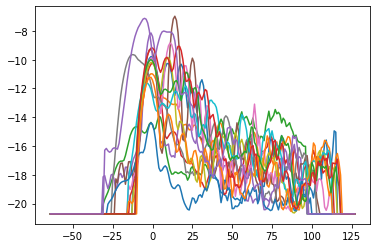

In [209]:
N=32000
range_param=[[-0.5,0.5],[-0.75,0.75],[0.2,1],[-0.1,0.1],[-400,400]]
data_path='C:\\Users\\Lenovo\\Desktop\\autocover_test\\transformer\\dataset1\\'
data_x=np.zeros(shape=(N,256-64))
data_y=np.zeros(shape=(N,5))

for i in range(N):
    if (i/N*100)%5==0:
        print('%d'%(i/N*100)+'%')
    t=h5py.File(data_path+'%05d.mat'%(i+1))
    MEL=t['MEL'][:]
    mel_pitch=np.int32(t['MelPitch'][0][0])
    if mel_pitch>60:
        print(i)
    param=t['Param'][:]
    #t=np.log(t+1e-20)
    data_x[i,128-mel_pitch-64:256-mel_pitch-64]=MEL[:,0]
    for j in range(5):
        data_y[i,j]=(np.float(param[j,0])-range_param[j][0])/(range_param[j][1]-range_param[j][0])
        
data_x=np.log(data_x+1e-9)
#print(data_x)
data_x=np.expand_dims(data_x,1)
#data_x=(data_x-np.mean(data_x))/np.max(data_x)
#data_x=-data_x
for j in range(15):
    t=random.randint(1,N-1)
    plt.plot([i for i in range(-128+64,128)],data_x[t,0,:])
#data_y=np.expand_dims(data_y,1)
print(np.shape(data_x))
print(np.shape(data_y))
print(data_y[1,:])
print(data_x.dtype)
print(data_y.dtype)

# Train the model

In [225]:
num_layers = 8
dff = 1024
num_heads = 8
input_size = 192
target_size = 5
dropout_rate = 0.01

input_data=keras.layers.Input(shape= [1,192]) 
output_data=Transformer(input_data, num_layers, input_size, num_heads,
                        dff, None, target_size, dropout_rate)

model = keras.models.Model(inputs= input_data, outputs= output_data)

In [203]:
model.summary()
#keras.utils.plot_model(model,show_shapes=True,expand_nested=True,to_file='model.png')

Model: "model_51"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_26 (InputLayer)           [(None, 1, 192)]     0                                            
__________________________________________________________________________________________________
dropout_290 (Dropout)           (None, 1, 192)       0           input_26[0][0]                   
__________________________________________________________________________________________________
tf.compat.v1.shape_206 (TFOpLam (3,)                 0           dropout_290[0][0]                
__________________________________________________________________________________________________
tf.__operators__.getitem_206 (S ()                   0           tf.compat.v1.shape_206[0][0]     
___________________________________________________________________________________________

In [227]:
opt = keras.optimizers.Adam(learning_rate=0.01,beta_1=0.9,beta_2=0.98,epsilon=1e-9)
model.compile(loss='mean_squared_error',optimizer=opt) 
tf_callback = tf.keras.callbacks.TensorBoard(log_dir="./logs")
history=model.fit(data_x,data_y,epochs=600, batch_size=16, verbose=1,validation_split=0.2,use_multiprocessing=True, callbacks=[tf_callback])

Epoch 1/600
1600/1600 [==============================] - 58s 34ms/step - loss: 0.0565 - val_loss: 0.0573
Epoch 2/600
1600/1600 [==============================] - 53s 33ms/step - loss: 0.0566 - val_loss: 0.0568
Epoch 3/600
1600/1600 [==============================] - 53s 33ms/step - loss: 0.0565 - val_loss: 0.0575
Epoch 4/600
1600/1600 [==============================] - 52s 33ms/step - loss: 0.0564 - val_loss: 0.0570
Epoch 5/600
1600/1600 [==============================] - 53s 33ms/step - loss: 0.0564 - val_loss: 0.0568
Epoch 6/600
1600/1600 [==============================] - 53s 33ms/step - loss: 0.0564 - val_loss: 0.0575
Epoch 7/600
1600/1600 [==============================] - 53s 33ms/step - loss: 0.0564 - val_loss: 0.0574
Epoch 8/600
1600/1600 [==============================] - 52s 33ms/step - loss: 0.0564 - val_loss: 0.0573
Epoch 9/600
1600/1600 [==============================] - 53s 33ms/step - loss: 0.0565 - val_loss: 0.0579
Epoch 10/600
1600/1600 [==============================]

Text(0, 0.5, 'MSE')

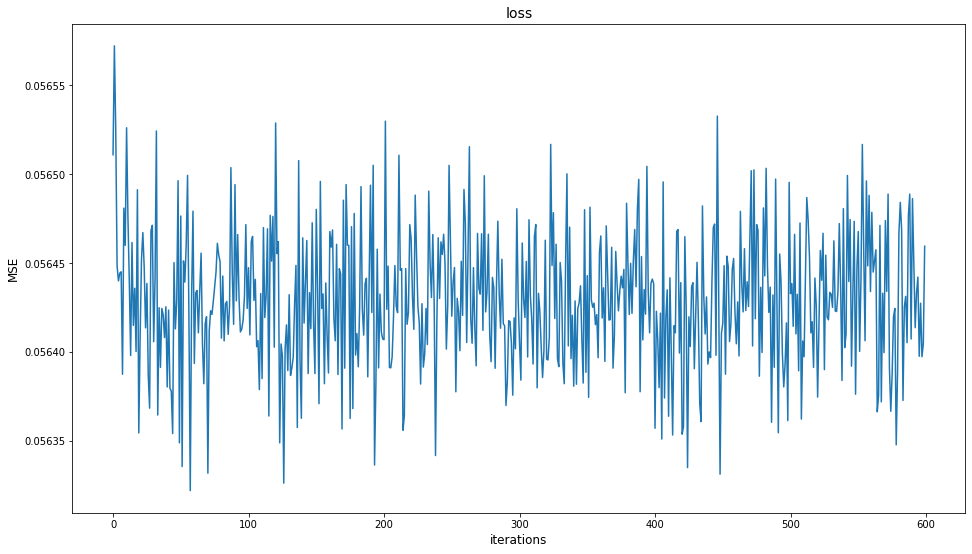

In [228]:
t=history.history['loss']
plt.figure(figsize=(16,9))
plt.plot([i for i in range(np.shape(t)[0])],t)
plt.title('loss',fontsize=14)
plt.xlabel('iterations',fontsize=12)
plt.ylabel('MSE',fontsize=12)

In [229]:
t_pred=keras.backend.function([model.input],[model.output])(data_x[:10])
t_pred=np.squeeze(t_pred)
print(t_pred[:10])
print(data_y[:10])
print()

[[0.54076004 0.4526642  0.49475533 0.5014541  0.5163597 ]
 [0.54076004 0.4526642  0.49475533 0.5014541  0.5163597 ]
 [0.54076004 0.4526642  0.49475533 0.5014541  0.5163597 ]
 [0.54076004 0.4526642  0.49475533 0.5014541  0.5163597 ]
 [0.54076004 0.45266423 0.49475533 0.5014541  0.5163597 ]
 [0.54076004 0.45266423 0.49475533 0.5014541  0.5163597 ]
 [0.54076004 0.45266423 0.49475533 0.5014541  0.5163597 ]
 [0.54076004 0.45266423 0.49475533 0.5014541  0.5163597 ]
 [0.54076004 0.4526642  0.49475533 0.5014541  0.5163597 ]
 [0.54076004 0.45266423 0.49475533 0.5014541  0.5163597 ]]
[[0.38190327 0.70884136 0.57336546 0.78309774 0.51946037]
 [0.82362259 0.41826979 0.9714122  0.30805659 0.53406037]
 [0.37519204 0.29596117 0.44863336 0.6368412  0.48698861]
 [0.34940438 0.31973449 0.59792742 0.802977   0.25370888]
 [0.15883861 0.43231586 0.57729158 0.50578059 0.38291699]
 [0.4983247  0.8815786  0.3900425  0.15363855 0.43816407]
 [0.49498237 0.04299626 0.87793802 0.46127001 0.69588742]
 [0.42007182 

In [ ]:
#model.save("C:\\Users\\Lenovo\\Desktop\\autocover_test\\transformer\\models\\transformer1.h5")
model.save("C:\\Users\\Lenovo\\Desktop\\autocover_test\\transformer\\models\\transformer_1.h5")
import pickle
with open('C:\\Users\\Lenovo\\Desktop\\autocover_test\\transformer\\models\\transformer_1_history.txt', 'wb') as file_pi:
    pickle.dump(history.history, file_pi)

Model: "model_6"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            [(None, 1, 192)]     0                                            
__________________________________________________________________________________________________
dropout_98 (Dropout)            (None, 1, 192)       0           input_7[0][0]                    
__________________________________________________________________________________________________
tf.compat.v1.shape_58 (TFOpLamb (3,)                 0           dropout_98[0][0]                 
__________________________________________________________________________________________________
tf.__operators__.getitem_58 (Sl ()                   0           tf.compat.v1.shape_58[0][0]      
____________________________________________________________________________________________

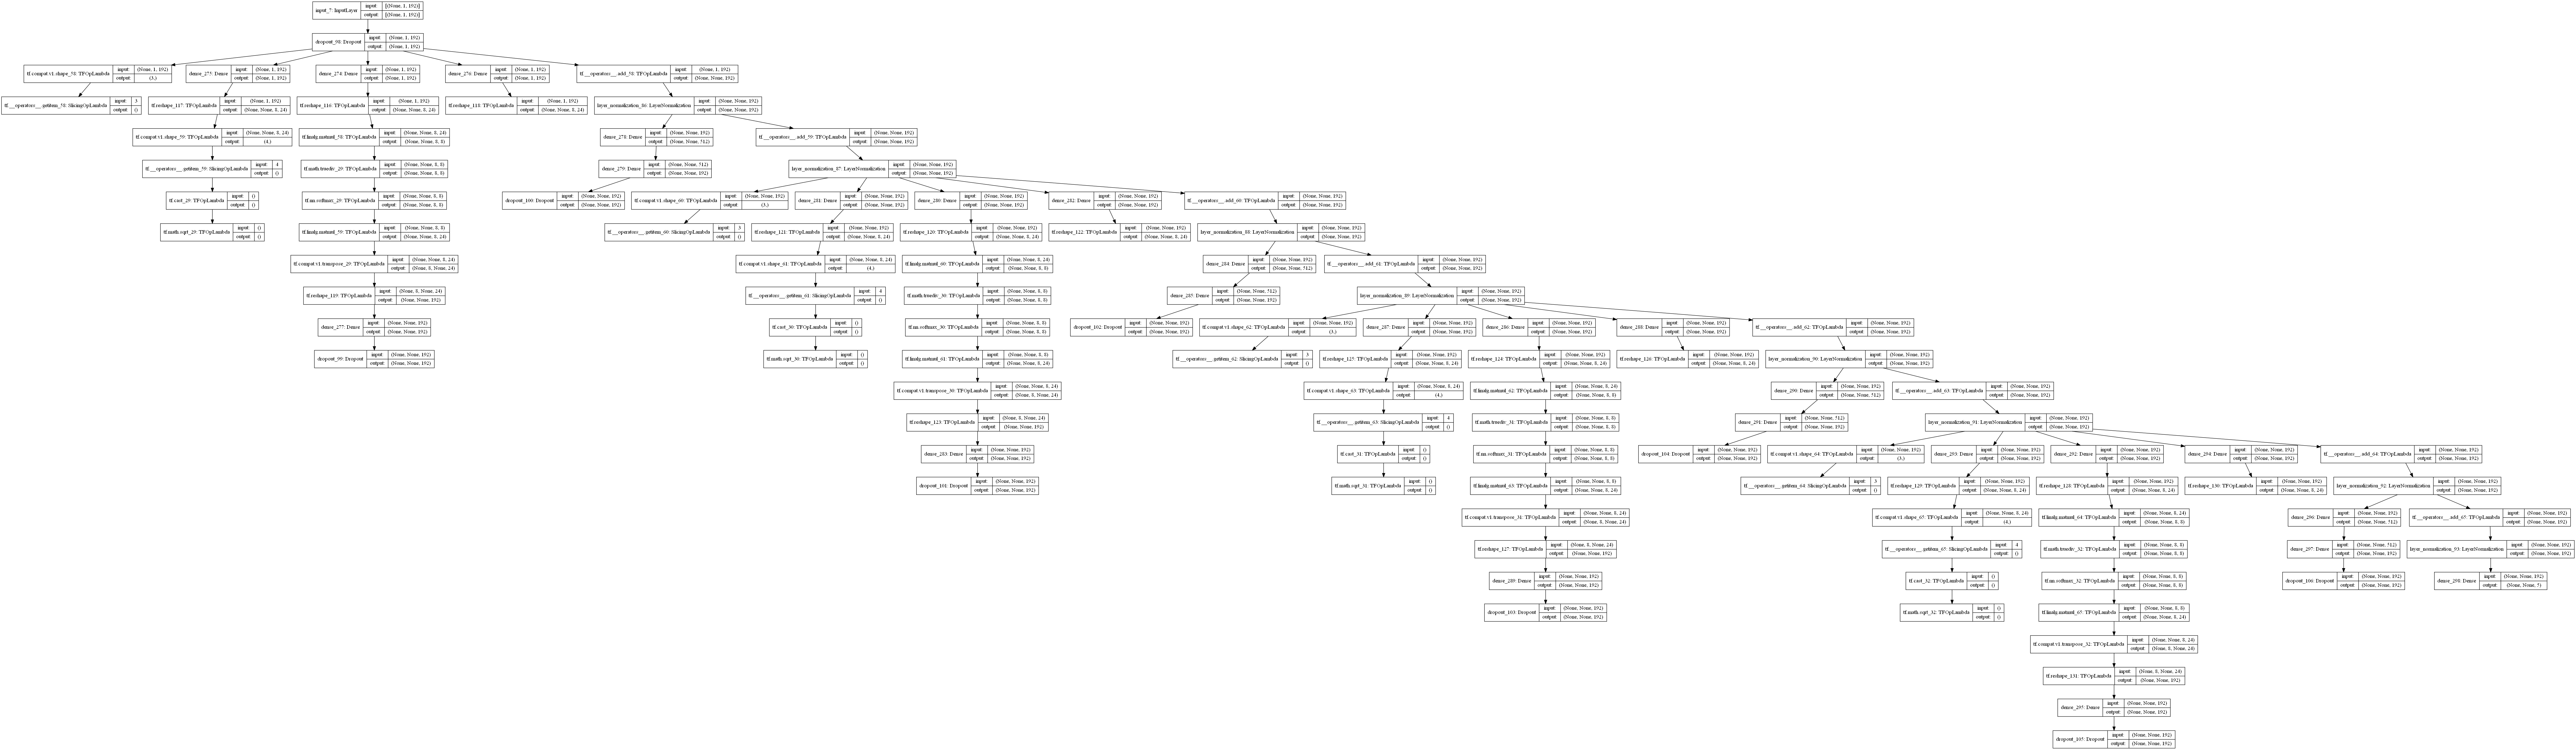

In [68]:
t = keras.models.load_model("C:\\Users\\Lenovo\\Desktop\\autocover_test\\transformer\\models\\transformer_test.h5")
t.summary()
keras.utils.plot_model(t,show_shapes=True,expand_nested=True,to_file='modelt.png')

In [69]:
%load_ext tensorboard

In [70]:
%tensorboard --logdir logs